In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
# data I/O
#data = open('input.txt', 'r').read() # should be simple plain text file
data = "AB#"
chars = list(set(data))
data_size, vocab_size = len(data), 3
print('data has %d characters, %d unique.' % (data_size, vocab_size))
#char_to_ix = { ch:i for i,ch in enumerate(chars) }
#ix_to_char = { i:ch for i,ch in enumerate(chars) }
mah_char_to_ix = {'A': 0, 'B': 1, '#': 2}
mah_ix_to_char = {0: 'A', 1: 'B', 2: '#'}


data has 3 characters, 3 unique.


In [3]:
PATTERN = "ABBA"

In [4]:
def chain_exec():
  pattern = PATTERN
  ret = list(np.random.randint(2, size=len(pattern)))
  while True:
    if ''.join( mah_ix_to_char[ix] for ix in ret[-len(pattern):]) == pattern:
      return ret + [mah_char_to_ix['#']]
    else:
      ret.append(np.random.randint(2))


In [5]:
def one_hot_chain(sequence):
  xs = torch.zeros( [len(sequence), vocab_size], dtype=torch.float64)
  for t in range(len(sequence)):

    #xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][sequence[t]] = 1
  return torch.transpose(torch.tensor(xs), 1,0)


In [6]:
one_hot_chain(chain_exec()).shape

/tmp/ipykernel_12266/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


torch.Size([3, 8])

In [7]:
''.join([ mah_ix_to_char[x] for x in chain_exec()])

'BAABBBBAABBA#'

In [8]:
from sklearn.manifold import TSNE

In [9]:
hidden_states = list()
states = list()

In [10]:
# STATE_NOTHING = 0
# STATE_A = 1
# STATE_AA = 2
# STATE_AAB = 3
# STATE_AABB = 4
# STATE_FINITO = 5


In [11]:
class Automata:
  def __init__(self, pattern):
    self.pattern = pattern + "#"
    self.state = ""

    # self.state = dict()
    # for i in range(len(pattern)+1):
    #   self.state[pattern[:i]] = dict()

    # print(self.state)
    # pass

  def transition(self, char):
    tentative_state = self.state + char
    #print(tentative_state)
    if tentative_state == self.pattern[:len(tentative_state)]:
      self.state = tentative_state
      #print("idziemy dalej", self.state)
    else:
      #print("kasza")
      for i in range(len(tentative_state)+1):
        #print(tentative_state[i:], "vs", self.pattern[:len(tentative_state)-i])
        if tentative_state[i:] == self.pattern[:len(tentative_state)-i]:
          self.state = tentative_state[i:]
          #print("najlepszy match to |", tentative_state[i:],"|")
          break
    return self.state

  def hsh(self):
    return len(self.state)

In [12]:
automat = Automata(PATTERN)
cur_state = automat.state

In [13]:
''.join([ mah_ix_to_char[x] for x in chain_exec()])

'BAAAABBA#'

In [14]:
for char in ''.join([ mah_ix_to_char[x] for x in chain_exec()]):
  print("pushing char", char, "current state is [",automat.state,"]",  "new state is", automat.transition(char))


pushing char B current state is [  ] new state is 
pushing char B current state is [  ] new state is 
pushing char B current state is [  ] new state is 
pushing char A current state is [  ] new state is A
pushing char B current state is [ A ] new state is AB
pushing char A current state is [ AB ] new state is A
pushing char A current state is [ A ] new state is A
pushing char A current state is [ A ] new state is A
pushing char B current state is [ A ] new state is AB
pushing char B current state is [ AB ] new state is ABB
pushing char B current state is [ ABB ] new state is 
pushing char B current state is [  ] new state is 
pushing char A current state is [  ] new state is A
pushing char B current state is [ A ] new state is AB
pushing char A current state is [ AB ] new state is A
pushing char A current state is [ A ] new state is A
pushing char B current state is [ A ] new state is AB
pushing char A current state is [ AB ] new state is A
pushing char A current state is [ A ] new sta

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def viz( hidden_states, states):
  last_hidden_states = hidden_states[-1000:]
  last_states               = states[-1000:]
  states_np = [ h_tensor.numpy() for h_tensor in last_hidden_states]
  states_np = np.asarray(states_np).reshape(-1,hidden_size)

  pca = PCA(n_components=2)
  X_embedded = pca.fit_transform(states_np)

  #tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
  #X_embedded = tsne.fit_transform(states_np)

  fig, ax = plt.subplots()
  scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=last_states)
  legend1 = ax.legend(handles=scatter.legend_elements()[0],
                    labels=[PATTERN[:i] for i in range(len(PATTERN+"#"))],
                    title="STATES")

  ax.add_artist(legend1)
  plt.show()

In [16]:
def token2char(token):
  if token.numpy().item(0) == 1.:
    char = 'A'
  if token.numpy().item(1) == 1.:
    char = 'B'
  if token.numpy().item(2) == 1.:
    char = '#'
  return char

In [17]:
def sample(seed_ix):
  """
  sample a sequence of integers from the model
  seed_ix is seed letter for first time step
  """
  # x = np.zeros((vocab_size, 1))
  # x[seed_ix] = 1
  x = seed_ix
  ixes = []

  h = torch.zeros([hidden_size, 1], dtype=torch.float64)


  #for t in range(n):
  t = 0
  while True:
    h = torch.tanh( torch.matmul(Wxh, x).add( torch.matmul( Whh, h).add(bh)) )
    y = torch.matmul(Why, h).add(by)
    ps = torch.nn.functional.softmax(y, dim=0)
    ix = np.random.choice(range(vocab_size), p=ps.detach().numpy().ravel())
    x = torch.zeros((vocab_size, 1), dtype=torch.float64)
    x[ix] = 1
    ixes.append(ix)
    if mah_ix_to_char[ix] == '#':
      break
  return ixes

In [18]:
def lossFunNasze(inputs, targets):

  n = inputs.size()[1]

  h = torch.zeros([hidden_size, 1], dtype=torch.float64, requires_grad=True)
  h_prev = torch.zeros([hidden_size, 1], dtype=torch.float64, requires_grad=True)
  loss = torch.zeros( [1], dtype=torch.float64, requires_grad=True)

  automat = Automata(PATTERN)
  state = automat.state

  weights = torch.tensor( [1., 1., 1.], dtype=torch.float64)

  for t in range(n):
    #h = torch.tanh( torch.matmul(Wxh, inputs[:,[t]]).add( torch.matmul( Whh, h_prev).add(bh)))
    h = torch.tanh( Wxh @ inputs[:,[t]] +  Whh @ h_prev + bh)
    hidden_states.append(h.detach().clone())
    state = automat.transition(token2char(inputs[:,[t]]))
    states.append( automat.hsh())
    y = torch.matmul(Why, h).add(by)
    ps = torch.nn.functional.softmax(y, dim=0)
    loss = loss - (torch.matmul(weights, ps)).mul(torch.log( torch.matmul(torch.transpose(ps, 1, 0), targets[:, [t]])))

    h_prev = h
  # print(loss)
  #print(2137, loss/n)
  return loss

In [19]:
import math

# hyperparameters
hidden_size = 20 # size of hidden layer of neurons
#seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = torch.tensor(np.random.randn(hidden_size, vocab_size)*0.1, requires_grad=True) # input to hidden
Whh = torch.tensor(np.random.randn(hidden_size, hidden_size)*0.1, requires_grad=True) # hidden to hidden
Why = torch.tensor(np.random.randn(vocab_size, hidden_size)*0.0, requires_grad=True) # hidden to output
bh = torch.tensor(np.random.randn(hidden_size, 1)*0.1, requires_grad=True) # hidden bias
by = torch.tensor(np.random.randn(vocab_size, 1)*0.1, requires_grad=True) # output bias

/tmp/ipykernel_12266/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


0 	 2 # #
100 	 2 # #


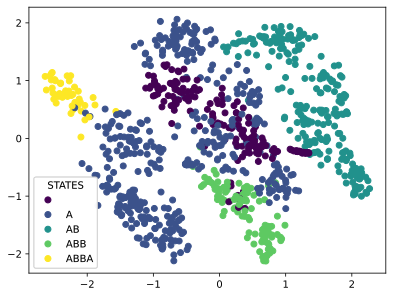

/tmp/ipykernel_12266/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


200 	 5 BBA# BBA#
300 	 5 ABBA# BBAABABAAABBA#
400 	 5 ABBA# BAAABABBBBAABAAAAAAAABBBABBA#
500 	 5 ABBA# ABBA#
600 	 5 ABBA# ABBBBABABBA#
700 	 5 ABBA# ABBBBAAABABBBAABBBBABABABBA#
800 	 5 ABBA# ABBBBBBBAAABBBABAAABBA#
900 	 5 ABBA# ABAAABBA#
1000 	 5 ABBA# BAABABABBBBABBA#
1100 	 5 ABBA# ABBA#


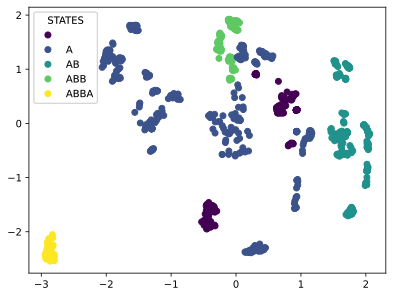

/tmp/ipykernel_12266/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


1200 	 5 ABBA# ABBA#
1300 	 5 ABBA# ABAABBA#
1400 	 5 ABBA# ABABBA#
1500 	 13 ABBA# BABABABABAABBBABBBAAAAABBBAAABAAABABBABBBBABBA#
1600 	 5 ABBA# ABAAAAAAAABBA#
1700 	 5 ABBA# AAABBBABBBABAAABBA#
1800 	 5 ABBA# BABBA#
1900 	 5 ABBA# AABBBABBBBBAAABBA#
2000 	 5 ABBA# BAAABABABAABABAAABAABBBBBABAAAABBBBAAAABAAAAAAAAAABBBBBAABBBAABBA#
2100 	 5 ABBA# ABAABAAAAAAABABBBBBBBBAAABBBBABBA#


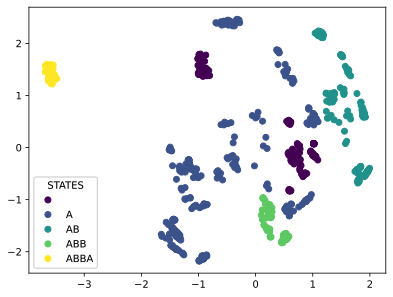

/tmp/ipykernel_12266/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


2200 	 5 ABBA# BBABABBA#
2300 	 5 ABBA# BAAABAABAABABAABBBBAAABBA#
2400 	 5 ABBA# BABAABBA#
2500 	 5 ABBA# ABBBAABAABAABABBBABAABBBBBABABBA#
2600 	 5 ABBA# ABABBBABAAAAAABABBBBBAAAABBBABBA#
2700 	 5 ABBA# BABBA#
2800 	 5 ABBA# AABABAAAAAAABAABABBBABAABAABABAABBBAABAABABAABABAABAAABBA#
2900 	 5 ABBA# ABBBBABBA#
3000 	 5 ABBA# ABBA#
3100 	 5 ABBA# AAAABABAABBBBABABABABABABABBA#


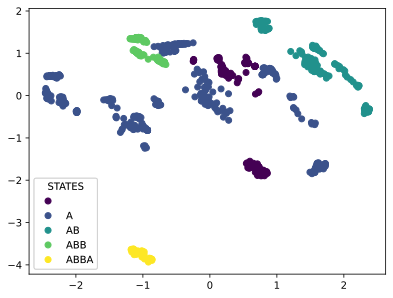

/tmp/ipykernel_12266/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


3200 	 5 ABBA# ABAABBA#
3300 	 5 ABBA# BABAAAABAAABBA#
3400 	 5 ABBA# BBBBBBAABABBA#
3500 	 5 ABBA# BAABABAAAAAABBBABAABAAABAAAABBBBBABABAAAAABBBBBBABABABABABABBBAABBA#
3600 	 5 ABBA# BAABBBBBBAAAAABAABAAABABBBBAABAABABBA#
3700 	 5 ABBA# AAABAABBBBAABBA#
3800 	 5 ABBA# BBBBAAAAABBBAABBBABABABAAABAAAABABABAABBBBBABAAABABAAABBBBBBAAAAAABAABABABAAAAAABBBABBA#
3900 	 5 ABBA# BABABBA#
4000 	 5 ABBA# AABBA#
4100 	 5 ABBA# BABBBBBAABAAABBBAAAABAAAABBBBBABBBABBA#


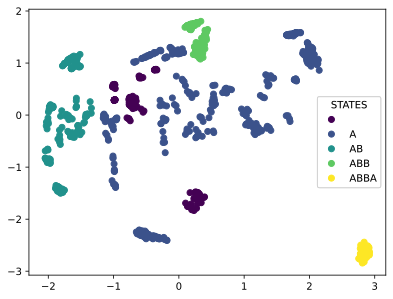

/tmp/ipykernel_12266/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


4200 	 5 ABBA# ABAABBA#
4300 	 5 ABBA# ABBBABABABAABAAAAAAABAABAABBBAAAAAAAAAABAAAABBA#
4400 	 5 ABBA# BABABBA#
4500 	 5 ABBA# BBBABBA#
4600 	 5 BBA# BBA#
4700 	 5 ABBA# BAAAABBBBBAAAAAAABAAABBA#
4800 	 5 ABBA# BABABABBBBBABBA#
4900 	 5 ABBA# BBBABBBABBBABBBABAAAAAABBA#


In [20]:
import torch.optim as optim

iterations = 5000
learning_rate = 1e-1
mWxh = torch.zeros_like(Wxh)
mWhh = torch.zeros_like(Whh)
mWhy = torch.zeros_like(Why)
mbh = torch.zeros_like(bh)
mby = torch.zeros_like(by)

history = []
for i in range(iterations):
  if i % 100 == 0:

    ixes = sample(one_hot_chain(chain_exec())[:, [0]])
    ixes_AB = ''.join([ mah_ix_to_char[x] for x in ixes])
    print(i,"\t", len(ixes_AB) - ixes_AB.find(PATTERN), ixes_AB[-len(PATTERN)-1:], ixes_AB)

  if i % 1000 == 100:
    viz(hidden_states, states)
  inputs = one_hot_chain(chain_exec())
  targets = inputs[:,1:]
  inputs  = inputs[:,:-1]

  loss = lossFunNasze(inputs, targets)
  history.append(loss.item())
  loss.backward()

  with torch.no_grad():
    for param, mem in zip([Wxh, Whh, Why, bh, by],
                          [mWxh, mWhh, mWhy, mbh, mby]):
      mem += param.grad.mul(param.grad )
      param += -learning_rate * param.grad / torch.sqrt( mem + 1e-8)
      param.grad.zero_()


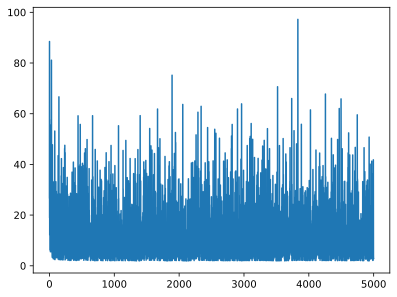

In [21]:
import matplotlib.pyplot as plt

plt.plot(history)
# ?????????????

In [22]:
import torch.optim as optim
optimizer = optim.Adagrad( [Wxh, Whh, Why, bh, by], lr=1e-1)

history = []
for i in range(iterations):
  if i % 100 == 0:

    ixes = sample(one_hot_chain(chain_exec())[:, [0]])
    ixes_AB = ''.join([ mah_ix_to_char[x] for x in ixes])
    print(i,"\t", ixes_AB[-5:], ixes_AB)

  optimizer.zero_grad()

  inputs = one_hot_chain(chain_exec())
  targets = inputs[:,1:]
  inputs  = inputs[:,:-1]

  loss = lossFunNasze(inputs, targets)
  history.append(loss.item())
  loss.backward()
  optimizer.step()
  # with torch.no_grad():
  #   Wxh -= Wxh.grad * learning_rate
  #   Whh -= Whh.grad * learning_rate
  #   Why -= Why.grad * learning_rate
  #   bh  -= bh.grad * learning_rate
  #   by  -= by.grad * learning_rate
  #   Wxh.grad.zero_()
  #   Whh.grad.zero_()
  #   Why.grad.zero_()
  #   bh.grad.zero_()
  #   by.grad.zero_()

/tmp/ipykernel_12266/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


0 	 ABBA# AAAABABBBBAABBBBABBBAAAAABABBBBAABBA#
100 	 ABBA# BABABAABBA#
200 	 ABBA# BBBABBBBBBBBABBBABBA#
300 	 ABBA# BBAAABABBBBBABABABABBA#
400 	 ABBA# BAAABAAABBBABBBBAABAAABAABABABBA#
500 	 ABBA# ABAAABAAABBBABAABABBA#
600 	 ABBA# BAABAAAABAAAABAABABBA#
700 	 ABBA# ABBA#
800 	 ABBA# ABAABABBBABBA#
900 	 ABBA# AABABABABBA#
1000 	 ABBA# AAABABBBBBBBBAAAABABABBA#
1100 	 ABBA# ABBA#
1200 	 BBA# BBA#
1300 	 ABBA# BAABBA#
1400 	 ABBA# BABAABBBBBABBBBABAABBA#
1500 	 ABBA# ABBA#


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history)
# ?????????????

In [ ]:
if False:
  inputs = one_hot_chain(chain_exec())
  targets = inputs[:,1:]
  inputs  = inputs[:,:-1]

  print(inputs[:,0])


  print(44, inputs)
  print(88, targets)
  n = inputs.size()[1]

  h = torch.zeros([hidden_size, 1], dtype=torch.float64, requires_grad=True)
  h_prev = torch.zeros([hidden_size, 1], dtype=torch.float64, requires_grad=True)

  h = torch.tanh( torch.matmul(Wxh, inputs[:,[0]]).add( bh))
  y = torch.matmul(Why, h).add(by)
  ps = torch.nn.functional.softmax(y, dim=0)
  loss = -torch.log( torch.matmul(torch.transpose(ps, 1, 0), targets[:, [0]]))


  for t in range(1, n):
    h = torch.tanh( torch.matmul(Wxh, inputs[:,[t]]).add( torch.matmul( Whh, h_prev).add(bh)))
    y = torch.matmul(Why, h).add(by)
    ps = torch.nn.functional.softmax(y, dim=0)
    loss = loss -torch.log( torch.matmul(torch.transpose(ps, 1, 0), targets[:, [t]]))
    h_prev = h

  print(h.size())
  loss.backward()
  with torch.no_grad():
    Wxh -= Wxh.grad * learning_rate
    Whh -= Whh.grad * learning_rate
    Why -= Why.grad * learning_rate
    bh  -= bh.grad * learning_rate
    by  -= by.grad * learning_rate
    Wxh.grad.zero_()
    Whh.grad.zero_()
    Why.grad.zero_()
    bh.grad.zero_()
    by.grad.zero_()

